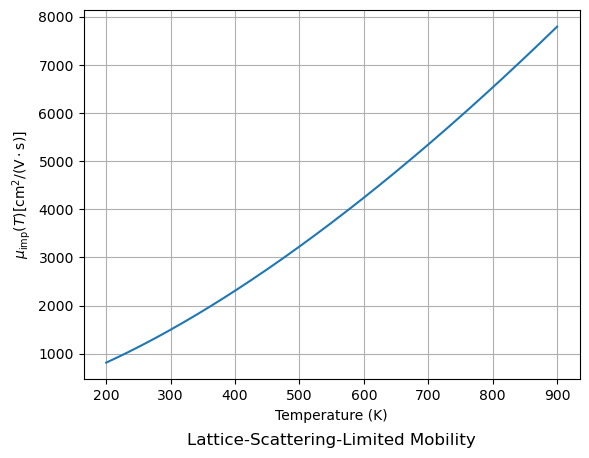

In [ ]:
from __future__ import annotations
import numpy as np
from sempy import ConstantsSI
from typing import Union
from dataclasses import dataclass, asdict
ArrayLike = Union[float, np.ndarray]

def tex_power(n: float) -> str:
    """Convert 1e16 → 10^{16} as a TeX string."""
    s = f"{n:.0e}"          # -> "1e16"
    base, exp = s.split("e")
    exp = int(exp)
    return rf"{base}\times 10^{{{exp}}}"

@dataclass
class ParametersBase:
  @property
  def kwargs(self):
    return asdict(self)

@dataclass
class LatticeMobilityParameters(ParametersBase):
    T_ref: float       # reference temperature
    mu_ref: float      # μ_lat at T_ref (cm^2/Vs)
    alpha: float = 1.5 # acoustic phonon exponent

def lattice_scattering_mobility(
    T: ArrayLike,
    T_ref: float,
    mu_ref: float,
    alpha: float = 3.0 / 2.0,
) -> np.ndarray:
  r"""
  Compute the lattice-scattering-limited mobility.

  This model assumes acoustic-phonon scattering, for which the
  mobility follows a power-law temperature dependence:

  .. math::

      \mu_{\mathrm{lat}}(T)
      = \mu_{\mathrm{lat}}(T_{\mathrm{ref}})
        \left( \frac{T}{T_{\mathrm{ref}}} \right)^{-\alpha_{\mathrm{lat}}}


    Parameters
    ----------
    T : float or ndarray
        Temperature(s) in Kelvin.
    T_ref : float
        Reference temperature (K) where mu_lattice_ref is defined.
    mu_ref : float
        Lattice-limited mobility at T_ref (units: cm^2/(V*s)).
    alpha : float, optional
        Temperature exponent for acoustic-phonon scattering.
        Typical value is 1.5.

    Returns
    -------
    ndarray
        Lattice-limited mobility mu_lat(T) in cm^2/(V*s).
  """
  T = np.asarray(T, dtype=float)
  return mu_ref * (T / T_ref) ** (-alpha)

from sempy import ImpurityMobilityParameters
from sempy import impurity_scattering_mobility
import numpy as np

si_impurity_scattering_parameters = ImpurityMobilityParameters(
  T_ref=300.0,
  NI_ref=1e16,
  mu_ref=1500.0,
  alpha_T=1.5,
)

T_array = np.linspace(200,900,200)
NI = 1e16
mu_impurity = impurity_scattering_mobility(
  T=T_array,
  NI = NI,
  **si_impurity_scattering_parameters.kwargs
)

import matplotlib.pyplot as plt
plt.plot(T_array, mu_impurity)
plt.xlabel("Temperature (K)")
plt.ylabel(r"$\mu_{\text{imp}}(T) [\mathrm{cm^2/(V \cdot s)}]$")
plt.title("Lattice-Scattering-Limited Mobility",y=-.2)
plt.grid(True)
plt.show()

In [8]:
@dataclass
class CarrierMobilityModel:
  """
  Mobility model for a single carrier type (electron or hole).

  m_eff : float
      Effective mass m* [kg].
  lattice : LatticeMobilityParameters
      Lattice scattering parameters.
  impurity : ImpurityMobilityParams | None
      Impurity scattering parameters (optional).
  """
  m_eff: float
  lattice: LatticeMobilityParameters
  impurity: ImpurityMobilityParameters | None = None

  def thermal_velocity(self, T: ArrayLike) -> np.ndarray:
    r"""
    Thermal (rms) velocity from equipartition:

        (1/2) m* v_th^2 = (3/2) k_B T
    """
    T = np.asarray(T, dtype=float)
    return np.sqrt(3.0 * ConstantsSI.k_B * T / self.m_eff)

    # --- 3.2 τ ↔ μ conversions -------------------------------------------

  def tau_from_mu(self, mu_cm2_Vs: ArrayLike) -> np.ndarray:
    r"""
    Mean free time `$\tau_c$` from mobility $\mu$:

        μ = q τ_c / m*

    μ is in cm^2/(V*s); internally convert to m^2/(V*s).
    """
    mu_m2 = np.asarray(mu_cm2_Vs, dtype=float) * 1e-4  # cm^2 → m^2
    return mu_m2 * self.m_eff / ConstantsSI.q

  def mu_from_tau(self, tau_c: ArrayLike) -> np.ndarray:
      r"""
      Mobility μ from mean free time τ_c:

          μ = q τ_c / m*

      Returned μ in cm^2/(V*s).
      """
      tau_c = np.asarray(tau_c, dtype=float)
      mu_m2 = ConstantsSI.q * tau_c / self.m_eff
      return mu_m2 * 1e4  # m^2 → cm^2

  # --- 3.3 Component mobilities ----------------------------------------

  def mu_lattice(self, T: ArrayLike) -> np.ndarray:
      """Lattice-limited mobility μ_lat(T)."""
      return lattice_scattering_mobility(
          T=T,
          **self.lattice.kwargs,
      )

  def mu_impurity(self, T: ArrayLike, NI: ArrayLike) -> np.ndarray:
      """Impurity-limited mobility μ_imp(T, N_I)."""
      if self.impurity is None:
          raise ValueError("Impurity parameters not set for this carrier.")
      return impurity_scattering_mobility(
          T=T,
          NI=NI,
          **self.impurity.kwargs,
      )

  # --- 3.4 Total mobility (Matthiessen) --------------------------------

  def mu_total(self, T: ArrayLike, N_I: ArrayLike) -> np.ndarray:
      r"""
      Total mobility using Matthiessen’s rule:

          1 / μ_tot = 1 / μ_lat + 1 / μ_imp
      """
      mu_lattice = self.mu_lattice(T)

      if self.impurity is None:
          return mu_lattice
      else:
        mu_impurity = self.mu_impurity(T, N_I)
        inv_mu = 1.0 / mu_lattice + 1.0 / mu_impurity
        return 1.0 / inv_mu

  # --- 3.5 Drift velocity ----------------------------------------------

  def drift_velocity(
      self,
      T: ArrayLike,
      N_I: ArrayLike,
      E: ArrayLike,
  ) -> np.ndarray:
      r"""
      Drift velocity:

          v_d(T, N_I, E) = μ_tot(T, N_I) * E

      μ in cm^2/(V*s), E in V/m → v_d in m/s.
      """
      mu_cm2 = self.mu_total(T, N_I)
      mu_m2 = mu_cm2 * 1e-4  # cm^2 → m^2
      E = np.asarray(E, dtype=float)
      return mu_m2 * E

@dataclass
class SemiconductorMobility:
    """
    Convenience wrapper holding both electron and hole mobility models.
    """
    electron: CarrierMobilityModel
    hole: CarrierMobilityModel

    # electrons (n-type)
    def mu_n(self, T: ArrayLike, NI: ArrayLike) -> np.ndarray:
        return self.electron.mu_total(T, NI)

    def mu_n_lattice(self, T: ArrayLike) -> np.ndarray:
        return self.electron.mu_lattice(T)

    def mu_n_impurity(self, T: ArrayLike, NI: ArrayLike) -> np.ndarray:
        return self.electron.mu_impurity(T, NI)

    def drift_velocity_n(self, T: ArrayLike, NI: ArrayLike, E: ArrayLike) -> np.ndarray:
        return self.electron.drift_velocity(T, NI, E)
    

    # holes (p-type)
    def mu_p(self, T: ArrayLike, NI: ArrayLike) -> np.ndarray:
        return self.hole.mu_total(T, NI)

    def mu_p_lattice(self, T: ArrayLike) -> np.ndarray:
        return self.hole.mu_lattice(T)

    def mu_p_impurity(self, T: ArrayLike, NI: ArrayLike) -> np.ndarray:
        return self.hole.mu_impurity(T, NI)

    def drift_velocity_p(self, T: ArrayLike, NI: ArrayLike, E: ArrayLike) -> np.ndarray:
        return self.hole.drift_velocity(T, NI, E)


In [9]:
from sempy import LatticeMobilityParameters
from sempy import ImpurityMobilityParameters
from sempy import CarrierMobilityModel
from sempy import SemiconductorMobility

lattice_n_si = LatticeMobilityParameters(
    T_ref=300.0,
    mu_ref=1500.0,
    alpha=1.5,
)
lattice_p_si = LatticeMobilityParameters(
    T_ref=300.0,
    mu_ref=450.0,
    alpha=1.5,
)

# Impurity params (Si-like)
impurity_n_si = ImpurityMobilityParameters(
    T_ref=300.0,
    NI_ref=1e16,
    mu_ref=1500.0,
    alpha_T=1.5,
)
impurity_p_si = ImpurityMobilityParameters(
    T_ref=300.0,
    NI_ref=1e16,
    mu_ref=450.0,
    alpha_T=1.5,
)

# Effective masses
m_eff_n_si = 0.26 * ConstantsSI.me0
m_eff_p_si = 0.39 * ConstantsSI.me0

# Carrier models
n_model = CarrierMobilityModel(
    m_eff=m_eff_n_si,
    lattice=lattice_n_si,
    impurity=impurity_n_si,
)
p_model = CarrierMobilityModel(
    m_eff=m_eff_p_si,
    lattice=lattice_p_si,
    impurity=impurity_p_si,
)

si_mob = SemiconductorMobility(electron=n_model, hole=p_model)

# quick sanity check
T = np.linspace(200, 900, 200)
NI = 1e16
mu_n = si_mob.mu_n(T, NI)
mu_p = si_mob.mu_p(T, NI)
v_dn = si_mob.drift_velocity_n(T=300.0, NI=NI, E=1e3)
v_dp = si_mob.drift_velocity_p(T=300.0, NI=NI, E=1e3)



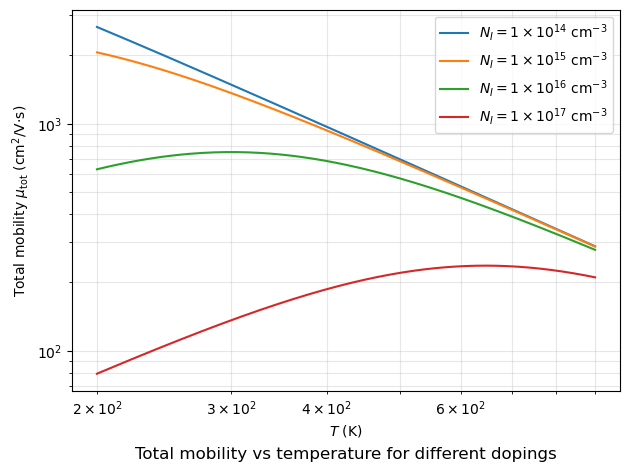

In [10]:
import matplotlib.pyplot as plt
from sempy import tex_power
# --- 1. Doping values ----------------------------------------------------


dopings = [1e14, 1e15, 1e16, 1e17]  # cm^-3

fig, ax = plt.subplots()

for NI in dopings:
    mu_lat = lattice_scattering_mobility(
        T=T,
        T_ref=lattice_n_si.T_ref,
        mu_ref=lattice_n_si.mu_ref,
        alpha=lattice_n_si.alpha,
    )

    mu_imp = impurity_scattering_mobility(
        T=T,
        NI=NI,
        T_ref=impurity_n_si.T_ref,
        NI_ref=impurity_n_si.NI_ref,
        mu_ref=impurity_n_si.mu_ref,
        alpha_T=impurity_n_si.alpha_T,
    )

    mu_tot = 1.0 / (1.0 / mu_lat + 1.0 / mu_imp)

    ax.loglog(T, mu_tot, label=rf"$N_I = {tex_power(NI)}\ \mathrm{{cm^{{-3}}}}$")

ax.set_xlabel(r"$T$ (K)")
ax.set_ylabel(r"Total mobility $\mu_{\mathrm{tot}}$ (cm$^2$/V·s)")
ax.grid(True, which="both", alpha=0.3)
ax.legend()
ax.set_title("Total mobility vs temperature for different dopings", y=-0.2)

plt.tight_layout()
plt.show()
